# Open Problems - Multimodal Single-Cell Integration

## Setup

In [1]:
import sys

sys.path.append("../working")

In [2]:
import logging

logging.basicConfig(
    # filename=__file__.replace('.py', '.log'),
    level=logging.getLevelName("INFO"),
    format="%(asctime)s [%(levelname)s] [%(module)s] %(message)s",
)

log = logging.getLogger(__name__)

In [3]:
import glob
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
from omegaconf import OmegaConf
from src.get_score import get_score
from src.load_data import InputData
from src.make_dataset import BaseDataset, get_transforms
from src.make_model import ImageBaseModel
from src.utils import df_stats
from torch.utils.data import DataLoader

pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", None)

2022-08-24 22:11:16,844 [INFO] [utils] Note: detected 88 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
2022-08-24 22:11:16,846 [INFO] [utils] Note: NumExpr detected 88 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2022-08-24 22:11:16,846 [INFO] [utils] NumExpr defaulting to 8 threads.


In [4]:
# Competition specific library

## 目的

このコンペティションの目的は、骨髄幹細胞がより成熟した血液細胞へと成長する過程で、DNA、RNA、タンパク質の測定値が単一細胞内でどのように共変動するかを予測することである。このコンペティションのために、細胞中心の創薬企業であるCellarity社が作成した、4人のヒトドナーのCD34+造血幹・前駆細胞（HSPC）の5時点の30万細胞の時間経過データセットのサブセットを用いて、トレーニングしたモデルを開発することになります。

テストセットでは、データセット内の未知の遅い時点から取得され、競技者は1つのモダリティを与えられ、同じセルで測定された対のモダリティを予測することを課される。このコンペティションの課題は、テストデータがトレーニングデータのどの時点のものよりも遅い時点のものであることである。

あなたの研究は、細胞の状態を何層にも分けて遺伝情報をマッピングする方法の技術革新を加速させるでしょう。もし、ある様式を別の様式から予測することができれば、これらの複雑な制御過程を支配する規則についての理解を深めることができるかもしれません。

![predict](./images/predict.png)

過去10年間、シングルセルゲノミクスの登場により、単一細胞内のDNA、RNA、タンパク質の測定が可能になった。これらの技術により、前例のないスケールと解像度で生物学を研究することが可能になった。その結果、ヒトの初期胚発生の詳細なマップ、新しい疾患関連細胞の発見、細胞を標的とした治療介入などが実現しました。さらに、最近の実験技術の進歩により、同一細胞内の複数のゲノムモダリティを測定することが可能になった。

マルチモーダルなシングルセルデータがますます利用できるようになる一方で、データ解析手法はまだ不足しています。単一細胞は体積が小さいため、測定値はまばらでノイズが多い。細胞間の分子サンプリング深さの違い（シーケンシング深さ）や、バッチで細胞を扱うことによる技術的効果（バッチ効果）は、しばしば生物学的な差異を圧倒することがあります。マルチモーダルデータを解析する場合、異なる特徴空間、モダリティ間およびバッチ間の共有および固有の変動を考慮する必要があります。さらに、現在の単一細胞データ解析のパイプラインは、たとえその下にダイナミックな生物学的プロセスがあったとしても、細胞を静的なスナップショットとして扱っている。時間経過に伴う状態の変化と同時に時間的なダイナミクスを考慮することは、シングルセルデータサイエンスにおける未解決の課題である。

一般に、遺伝情報はDNA→RNA→タンパク質と流れる。RNA（GEXデータ）を生成するためにはDNAにアクセスできなければならず（ATACデータ）、RNAはタンパク質を生成するための鋳型として利用される（ADTデータ）。これらのプロセスは、フィードバックによって制御されています。例えば、タンパク質がDNAと結合することで、より多くのRNAが生成されるのを防ぐことができます。このような遺伝子の制御が、生物が発展し、環境の変化に適応していくためのダイナミックな細胞プロセスの基盤となっているのです。単一細胞データ科学では、動的プロセスは、生物学的プロセスの進行を捕らえる、いわゆる擬似時間アルゴリズムによってモデル化されてきた。しかし、これらのアルゴリズムを一般化し、擬似時間と実時間の両方を考慮することは、まだ未解決の問題である。

コンペティション主催のOpen Problems in Single-Cell Analysisは、シングルセル解析手法のベンチマークを標準化するための、オープンソースかつコミュニティ主導の取り組みです。Open Problemsの中核となる取り組みには、既存の課題を測定可能なタスクに形式化すること、高品質のデータセットを収集すること、コミュニティから提供された手法のベンチマークを集中的に行うこと、多様な手法開発者を集めてシングルセルのアルゴリズムを改善するコミュニティに焦点を当てたイベントを開催することなどがあります。彼らは、Cellarity、Chan Zuckerbeg Biohub、Chan Zuckerberg Initiative、Helmholtz Munich、Yaleと提携し、学際的なコラボレーションを通じて、遺伝的ダイナミックスの時間的変化を予測することにどんな進展が見られるかに期待しています。

人体には約37兆個の細胞が存在し、それぞれが異なる行動や機能を有しています。一つのゲノムがどのようにして多様な細胞状態を生み出すのかを理解することは、健康や病気において組織がどのように機能し、どのように誤作動を起こすのかをメカニズム的に理解するための鍵となります。あなたは、この単一細胞生物学の基本的な課題の解決に貢献することができます。予測問題を長期にわたって解くことができれば、血液や免疫細胞の成熟に伴う分化に遺伝子制御がどのように影響するかについて、新たな知見を得ることができるかもしれません。


## 評価

投稿の順位付けには、ピアソン相関係数を使用しています。Multiomeデータセットの各オブザベーションについて、グランドトゥルース遺伝子発現と予測される遺伝子発現の相関を計算します。CITEseqデータセットの各オブザベーションについて、ground-truthの表面タンパク質レベルと予測される表面タンパク質レベルの間の相関を計算します。総合スコアは、各サンプルの相関スコアの平均値です。あるサンプルの予測値がすべて同じであった場合、そのサンプルの相関は-1.0としてスコア化されます。


## 提出ファイル

評価セット内の各idについて、そのrow_idの ターゲット値を予測する必要があります。提出物はヘッダーを含み、以下のフォーマットである必要があります。



```
row_id,target
0,0.0
1,0.0
2,0.0
3,0.0
...
```

提出ファイルは、テストセットのオブザベーションのサブセットのみを含む必要があります。含まれるべき特定の ID については、データ説明を参照してください。




## データ

このコンペティションのデータセットは、4人の健康なヒトドナーから分離した動員末梢CD34+造血幹細胞および前駆細胞（HSPCs）から収集したシングルセルマルチオミクスデータから構成されています。細胞の詳細については、ベンダーのウェブサイトをご覧ください。

測定は10日間にわたり、5つの時点で行われた。各時点の各プレートから、2種類のシングルセルアッセイで測定するために細胞を採取した。1つ目は10x Chromium Single Cell Multiome ATAC + Gene Expressiontechnology（Multiome）、2つ目は10x Genomics Single Cell Gene Expression with Feature Barcodingtechnologyで、TotalSeq™-B Human Universal Cocktail, V1.0(CITEseq) を使用したもの。

このデータ型を扱ったことがない方は、この説明の一番下にいくつかのリンクを載せています。

各アッセイ技術では、2つのモダリティを測定します。Multiomeキットはクロマチンアクセシビリティ（DNA）と遺伝子発現（RNA）を、CITEseqキットは遺伝子発現（RNA）と表面タンパク質のレベルを測定します。

分子生物学のセントラルドグマに従うとDNA→RNA→タンパク質という分子生物学のセントラルドグマに従って、あなたの仕事は次の通りです。

- Multiomeサンプルの場合：クロマチンアクセシビリティが与えられた場合、遺伝子発現を予測する。
- CITEseqサンプルについて：遺伝子発現が与えられた場合、タンパク質量を予測する。

### 細胞の種類

解析の参考のため、以下の論文の情報を用いて、RNA 遺伝子発現に基づく予備的な細胞タイプアノテーションを行った： https://www.nature.com/articles/ncb3493 .細胞タイプのアノテーションは不正確な技術であり、連続データに離散的なラベルを割り当てるという概念には固有の限界があることに注意してください。これらのラベルを予測に使用する必要はなく、主に探索的な解析のガイドとして提供されている。このデータでは、以下のような細胞タイプがある。

- MasP= マスト細胞プロジェニター
- MkP＝メガカリョク細胞プロジェニター
- NeuP= 好中球プロジェニター
- MoP= Monocyte Progenitor（単球前駆体）。
- EryP= 赤血球前駆体（Erythrocyte Progenitor）。
- HSC= Hematoploetic Stem Cell（造血幹細胞）。
- BP= B細胞プロジェニター


### ファイルおよびフィールドの説明

- metadata.csv
    - cell_id- 観測された各セルに対する一意の識別子．
    - donor- 4人の細胞ドナーの識別子。
    - day- 観察が行われた実験の日。
    - 技術-citeseqか multiomeのどちらか。
    - cell_type- 上記のセルタイプの1つ，あるいは非表示．

実験観測はいくつかの大きなアレイに含まれています。これらのアレイはHDF5フォーマットで提供されます。


#### マルチオーム

- `train/test_multi_inputs.h5`- ATAC-seq peak counts をTF-IDFで変換し、デフォルトのlog(TF) * log(IDF)output (chromatin accessibility)を使用。行は細胞、列はアクセスレベルを測定したゲノムの位置（ここでは 10xReferences - 2020-A (July 7, 2020) で提供された参照ゲノム GRCh38 のゲノム座標により特定）に相当します。
- `train_multi_targets.h5`- RNA遺伝子発現レベル（同一細胞のライブラリサイズ正規化およびlog1p変換カウントとして）。


#### CITEseq

- `train/test_cite_inputs.h5`- RNAライブラリサイズで正規化、log1p変換したカウント値（遺伝子発現レベル）、行は{gene_name}_{gene_ensemble-ids}で指定したセル、列は遺伝子に対応。
- `train_cite_targets.h5`-dsbで正規化された同じ細胞の表面タンパク質レベル。


#### データ分割

データ分割は以下のように整理されている。

- トレーニングセットは、13176、31800、32606のドナーからのサンプルだけから構成される。公開テストセットは、ドナー27678からのサンプルだけから構成される。プライベートテストセットは、4人のドナーすべてからのサンプルで構成される。
- Multiomeサンプルについては、トレーニングセットは2日目、3日目、4日目、7日目のサンプルのみで構成されています。公開テストセットは、2日目、3日目、7日目のデータのみから構成される。プライベートテストセットは、10日目のデータのみから構成される。
- CITEseqサンプルについては、トレーニングセットは2日目、3日目、4日目のサンプルのみから構成されています。公開テストセットも2日目、3日目、4日目のみのサンプルから構成される。プライベートテストセットは、7日目のサンプルだけから構成されます。どの分割においても、10日目のCITEseqサンプルは存在しない。

![data split](./images/data-split.jpg)


あなたの課題は、テストセットの入力に対応するラベルを予測することです。提出物の採点を容易にするため、マルチオームデータのサブセットに対する予測のみを要求します。このサブセットは、Multiomeの行の30%、各行に対して列の15%をサンプリングして作成されています。列のサンプルは行ごとに異なります。CITEseqラベルは全てスコア化されています。

- `evaluation_ids.csv`- 評価対象のテストセットからラベルを特定する。ラベルマトリックスのcell_id/gene_id識別子から、提出ファイルに必要なrow_idへの結合キーが提供されます。
- `sample_submission.csv`- 正しい形式の投稿ファイルのサンプルです。詳しくは、評価のページをご覧ください。

### 学習リソース

- Open Problems - マルチモーダル単一細胞データについて- マルチモーダルデータを初めて見る人に説明するために昨年作成した情報ページです。
  https://openproblems.bio/neurips_docs/data/about_multimodal/
- モデル、推論、アルゴリズム - マルチモーダル単一細胞解析で競争するために団結する- コンペティションの背景と動機を提供するBroad Institutes Models, Inferences, and Algorithmsセミナーでコンペティション主催者によって発表された講演です。


## EDA メモ

- すべてのデータの読み込みに 40分 ほど必要  
  ![data-loading-time](./images/data-loading-time.png)




In [5]:
c = OmegaConf.load("../working/config/main.yaml")

input = InputData(c, use_fold=True, do_preprocess=True)

2022-08-24 22:11:19,322 [INFO] [load_data] Load feather file. path: ../input/evaluation_ids.f
2022-08-24 22:11:26,123 [INFO] [utils] Mem. usage decreased to 125Mb: 16% reduction
2022-08-24 22:11:26,472 [INFO] [load_data] Load feather file. path: ../input/metadata.f
2022-08-24 22:11:26,592 [INFO] [utils] Mem. usage decreased to 7.2Mb: 32% reduction
2022-08-24 22:11:26,597 [INFO] [load_data] Load feather file. path: ../input/sample_submission.f
2022-08-24 22:11:28,929 [INFO] [utils] Mem. usage decreased to 501Mb: 49% reduction
2022-08-24 22:11:28,932 [INFO] [load_data] Load original file. path: ../input/test_cite_inputs.h5
2022-08-24 22:12:33,493 [INFO] [utils] Mem. usage decreased to 409Mb: 0.% reduction
2022-08-24 22:12:33,545 [INFO] [load_data] Load original file. path: ../input/test_multi_inputs.h5
2022-08-24 22:24:41,921 [INFO] [utils] Mem. usage decreased to 488Mb: 0.% reduction
2022-08-24 22:24:42,649 [INFO] [load_data] Load original file. path: ../input/train_cite_inputs.h5
2022-

## Training Data



In [7]:
input.train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 754 entries, 0 to 753
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   image_id    754 non-null    object 
 1   center_id   754 non-null    int8   
 2   patient_id  754 non-null    object 
 3   image_num   754 non-null    int8   
 4   label       754 non-null    int8   
 5   label_CE    754 non-null    uint8  
 6   label_LAA   754 non-null    uint8  
 7   fold        754 non-null    float32
dtypes: float32(1), int8(3), object(2), uint8(2)
memory usage: 18.5+ KB


In [8]:
input.train.head()

,image_id,center_id,patient_id,image_num,label,label_CE,label_LAA,fold
0,006388_0,11,006388,0,0,1,0,1.0
1,008e5c_0,11,008e5c,0,0,1,0,3.0
2,00c058_0,11,00c058,0,1,0,1,3.0
3,01adc5_0,11,01adc5,0,1,0,1,2.0
4,026c97_0,4,026c97,0,0,1,0,2.0


In [9]:
input.train.tail()

,image_id,center_id,patient_id,image_num,label,label_CE,label_LAA,fold
749,fe9645_0,3,fe9645,0,0,1,0,1.0
750,fe9bec_0,4,fe9bec,0,1,0,1,1.0
751,ff14e0_0,6,ff14e0,0,0,1,0,3.0
752,ffec5c_0,7,ffec5c,0,1,0,1,2.0
753,ffec5c_1,7,ffec5c,1,1,0,1,2.0


In [10]:
input.train.describe()

,center_id,image_num,label,label_CE,label_LAA,fold
count,754.000000,754.000000,754.000000,754.000000,754.000000,754.000000
mean,7.115385,0.226790,0.274536,0.725464,0.274536,1.960212
std,3.504306,0.599046,0.446576,0.446576,0.446576,1.413653
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,7.000000,0.000000,0.000000,1.000000,0.000000,2.000000
75%,11.000000,0.000000,1.000000,1.000000,1.000000,3.000000
max,11.000000,4.000000,1.000000,1.000000,1.000000,4.000000


In [11]:
df_stats(input.train)

,カラム名,ユニーク値数,最頻値,最頻値の出現回数,最頻値の割合,欠損値の数,欠損値の割合,タイプ
0,image_id,754,006388_0,1,0.132626,0,0.0,object
1,center_id,11,11,257,34.084881,0,0.0,int8
2,patient_id,632,91b9d3,5,0.663130,0,0.0,object
3,image_num,5,0,632,83.819629,0,0.0,int8
4,label,2,0,547,72.546419,0,0.0,int8
5,label_CE,2,1,547,72.546419,0,0.0,uint8
6,label_LAA,2,0,547,72.546419,0,0.0,uint8
7,fold,5,2.0,160,21.220159,0,0.0,float32


### ラベル分布


In [12]:
input.train[c.settings.label_name].value_counts()

0    547
1    207
Name: label, dtype: int64

<AxesSubplot:xlabel='label', ylabel='Count'>

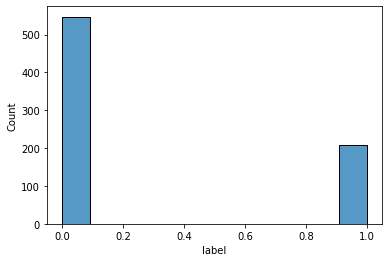

In [13]:
sns.histplot(input.train[c.settings.label_name])

### 特徴量分布

In [14]:
input.train["image_num"].value_counts()

0    632
1     89
2     21
3      8
4      4
Name: image_num, dtype: int64

<AxesSubplot:xlabel='image_num', ylabel='Count'>

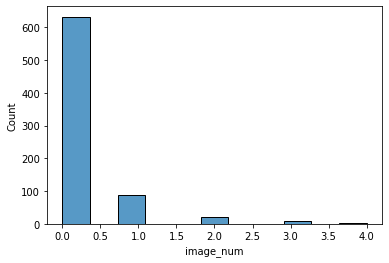

In [15]:
sns.histplot(input.train["image_num"])

In [16]:
input.train["center_id"].value_counts()

11    257
4     114
7      99
1      54
3      49
10     44
5      38
6      38
2      29
8      16
9      16
Name: center_id, dtype: int64

<AxesSubplot:xlabel='center_id', ylabel='Count'>

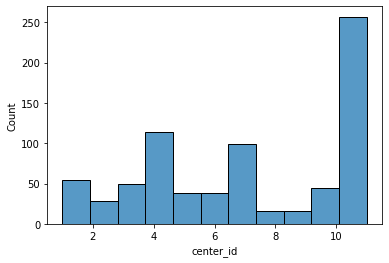

In [17]:
sns.histplot(input.train["center_id"])

### 画像

In [18]:
sample_image_id = input.train.loc[0, "image_id"]
sample_image_id

'006388_0'

In [19]:
sample_image_path = os.path.join(c.settings.dirs.train_image, sample_image_id + ".tif")
sample_image_path

'/data/home/shared/mayo-clinic-strip-ai/train/006388_0.tif'

In [20]:
# image = tiff.imread(sample_image_path)

In [21]:
# type(image)

In [22]:
# image.shape
# (60797, 34007, 3)

In [23]:
# plt.imshow(image, interpolation="nearest")
# plt.show()

- 006388_0.tif 1.3GB

![image](https://user-images.githubusercontent.com/1638500/177932885-96f4698a-e938-4bb3-8358-8e2905c76078.png)

- 86e319_1.tif 489MB

![image](https://user-images.githubusercontent.com/1638500/178005877-83561ada-0b0c-4ee7-b6e3-b2814dae68b5.png)

- 4ded24_0.tif 7.1MB

![image](https://user-images.githubusercontent.com/1638500/178181062-e13190ae-5e8a-4ea6-bf78-7491650131ca.png)


In [24]:
# メモリマップ

with tiff.TiffFile(sample_image_path) as f:
    mmap = f.asarray(out="memmap")

In [25]:
mmap.shape

(60797, 34007, 3)

In [26]:
image_good = np.asarray(mmap[42500:47500, 2500:7500, :])

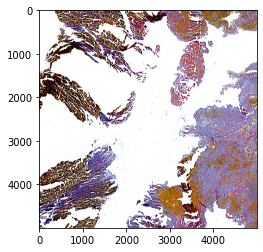

In [27]:
plt.imshow(image_good, interpolation="hanning")
plt.show()

In [28]:
np.mean(image_good)

188.69509270666666

In [29]:
np.median(image_good)

252.0

In [30]:
image_micro = np.asarray(mmap[45000:46000, 6500:7500, :])

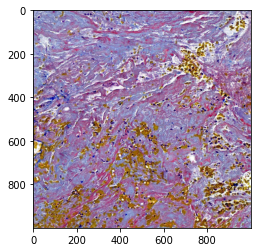

In [31]:
plt.imshow(image_micro, interpolation="hanning")
plt.show()

In [32]:
np.mean(image_micro)

144.85992366666667

In [33]:
np.median(image_micro)

146.0

In [34]:
image_bad = np.asarray(mmap[22500:27500, 2500:7500, :])

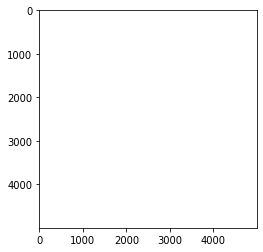

In [35]:
plt.imshow(image_bad, interpolation="hanning")
plt.show()

In [36]:
np.mean(image_bad)

255.0

In [37]:
image_micro_bad = np.asarray(mmap[45000:46000, 2000:3000, :])

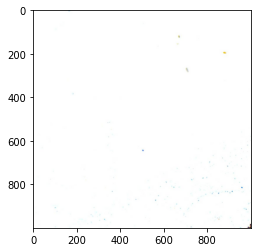

In [38]:
plt.imshow(image_micro_bad, interpolation="hanning")
plt.show()

In [39]:
np.mean(image_micro_bad)

254.76309366666666

In [40]:
np.median(image_micro_bad)

255.0

## Other Data



In [41]:
input.other.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396 entries, 0 to 395
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   image_id         396 non-null    object 
 1   patient_id       396 non-null    object 
 2   image_num        396 non-null    int8   
 3   other_specified  62 non-null     object 
 4   label            396 non-null    int8   
 5   label_Unknown    396 non-null    uint8  
 6   fold             396 non-null    float32
dtypes: float32(1), int8(2), object(3), uint8(1)
memory usage: 12.1+ KB


In [42]:
input.other.head()

,image_id,patient_id,image_num,other_specified,label,label_Unknown,fold
0,01f2b3_0,01f2b3,0,NaN,2,1,0.0
1,01f2b3_1,01f2b3,1,NaN,2,1,0.0
2,02ebd5_0,02ebd5,0,NaN,2,1,1.0
3,0412ab_0,0412ab,0,NaN,2,1,4.0
4,04414e_0,04414e,0,Hypercoagulable,2,1,2.0


In [43]:
input.other.tail()

,image_id,patient_id,image_num,other_specified,label,label_Unknown,fold
391,faaa7e_0,faaa7e,0,NaN,2,1,4.0
392,fd0f11_0,fd0f11,0,NaN,2,1,1.0
393,fd0f11_1,fd0f11,1,NaN,2,1,1.0
394,fd83c3_0,fd83c3,0,NaN,2,1,2.0
395,febb2b_0,febb2b,0,NaN,2,1,3.0


In [44]:
input.other.describe()

,image_num,label,label_Unknown,fold
count,396.000000,396.0,396.0,396.000000
mean,0.196970,2.0,1.0,1.909091
std,0.529237,0.0,0.0,1.418438
min,0.000000,2.0,1.0,0.000000
25%,0.000000,2.0,1.0,1.000000
50%,0.000000,2.0,1.0,2.000000
75%,0.000000,2.0,1.0,3.000000
max,4.000000,2.0,1.0,4.000000


In [45]:
df_stats(input.other)

,カラム名,ユニーク値数,最頻値,最頻値の出現回数,最頻値の割合,欠損値の数,欠損値の割合,タイプ
0,image_id,396,01f2b3_0,1,0.252525,0,0.000000,object
1,patient_id,336,0b5827,5,1.262626,0,0.000000,object
2,image_num,5,0,336,84.848485,0,0.000000,int8
3,other_specified,9,Dissection,27,84.343434,334,84.343434,object
4,label,1,2,396,100.000000,0,0.000000,int8
5,label_Unknown,1,1,396,100.000000,0,0.000000,uint8
6,fold,5,0.0,87,21.969697,0,0.000000,float32


### ラベル分布


In [46]:
input.other[c.settings.label_name].value_counts()

2    396
Name: label, dtype: int64

<AxesSubplot:xlabel='label', ylabel='Count'>

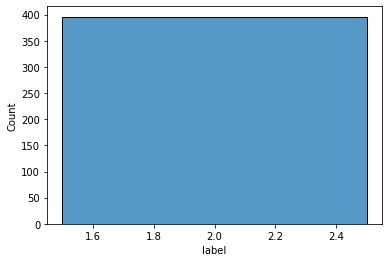

In [47]:
sns.histplot(input.other[c.settings.label_name])

In [48]:
input.other["other_specified"].value_counts()

Dissection             27
Hypercoagulable        14
PFO                    10
Stent thrombosis        3
Catheter                2
Trauma                  2
Takayasu vasculitis     2
tumor embolization      1
Endocarditis            1
Name: other_specified, dtype: int64

<AxesSubplot:xlabel='other_specified', ylabel='Count'>

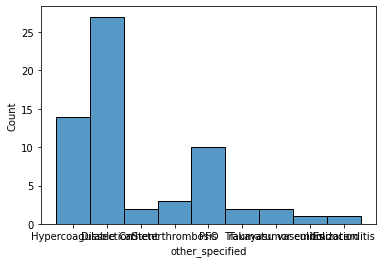

In [49]:
sns.histplot(input.other["other_specified"])

### 特徴量分布

In [50]:
input.other["image_num"].value_counts()

0    336
1     47
2      9
3      3
4      1
Name: image_num, dtype: int64

<AxesSubplot:xlabel='image_num', ylabel='Count'>

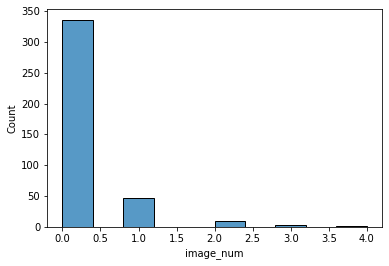

In [51]:
sns.histplot(input.other["image_num"])

## Test Data


In [52]:
input.test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4 entries, 0 to 3
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_id    4 non-null      object
 1   center_id   4 non-null      int8  
 2   patient_id  4 non-null      object
 3   image_num   4 non-null      int8  
dtypes: int8(2), object(2)
memory usage: 200.0+ bytes


In [53]:
input.test.head()

,image_id,center_id,patient_id,image_num
0,006388_0,11,006388,0
1,008e5c_0,11,008e5c,0
2,00c058_0,11,00c058,0
3,01adc5_0,11,01adc5,0


## Sample Submission




In [54]:
input.sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4 entries, 0 to 3
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   patient_id  4 non-null      object 
 1   CE          4 non-null      float32
 2   LAA         4 non-null      float32
dtypes: float32(2), object(1)
memory usage: 192.0+ bytes


In [55]:
input.sample_submission.head()

,patient_id,CE,LAA
0,006388,0.5,0.5
1,008e5c,0.5,0.5
2,00c058,0.5,0.5
3,01adc5,0.5,0.5


## Preprocess

規定した大きさで slice して、白紙部分が多かったら、その画像は捨てる。

In [56]:
sliced_images = glob.glob("../preprocess/train/*.npy")

In [57]:
sliced_images[1]

'../preprocess/train/008e5c_0_1024.npy'

In [58]:
input.train[input.train["image_id"] == "86e319_1"].index

Int64Index([407], dtype='int64')

In [59]:
len(sliced_images)

1508

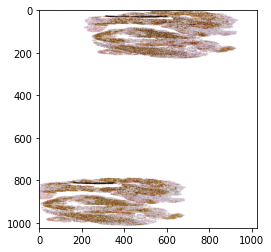

In [60]:
array = np.load(sliced_images[1], allow_pickle=True)
plt.imshow(array, interpolation="hanning")
plt.show()

In [61]:
array.mean()

232.8652311960856

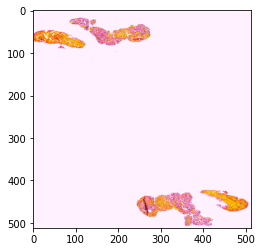

In [62]:
array = np.load(sliced_images[-1], allow_pickle=True)
plt.imshow(array, interpolation="hanning")
plt.show()

In [63]:
array.mean()

244.22024154663086

## Dataset

In [64]:
# ds = BaseDataset(c, input.train)
ds = BaseDataset(c, pd.concat([input.train, input.other]))

for i in range(1):
    image, label = ds[i]
    plt.imshow(image)
    plt.title(f"label: {label}")
    plt.show()

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [ ]:
# ds = BaseDataset(c, input.train, transform=get_transforms(c, "light"))
ds = BaseDataset(c, pd.concat([input.train, input.other]), transform=get_transforms(c, "light"))

for i in range(1):
    image, label = ds[i]
    plt.imshow(image[0])
    plt.title(f"label: {label}")
    plt.show()

## Model

In [ ]:
model = ImageBaseModel(c)
model

In [ ]:
# ds = BaseDataset(c, input.train, transform=get_transforms(c, "light"))
ds = BaseDataset(c, pd.concat([input.train, input.other]), transform=get_transforms(c, "light"))
loader = DataLoader(ds, batch_size=4, shuffle=True, num_workers=4, pin_memory=True, drop_last=True)

for image, label in loader:
    output = model(image)
    print(output)
    break